<a href="https://colab.research.google.com/github/weonyee/fisa04/blob/main/0224_Bank_Marketing_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 은행 마케팅 데이터셋을 활용한 분류기 만들기
-  `분류(classification)`: 새로운 관측값이 주어졌을 때, 그 관측값이 미리 정의된 여러 범주(하위 집단) 중 어느 하나에 속하는지를 결정하는 문제
- 은행 마케팅 데이터셋을 사용하여, 몇 가지 속성에 따라 누군가가 예금을 할지 여부를 예측하는 모델을 만들어 보겠습니다.
- 각 모델을 구축한 후, 모델을 평가하고 우리 사례에 가장 적합한 모델이 무엇인지 비교해보겠습니다.
- GridSearch를 사용해 모델의 하이퍼파라미터를 튜닝하여 모델을 최적화해 보겠습니다. 데이터셋에서 나온 예측 결과를 저장하고, 나중에 다시 사용할 수 있도록 모델을 저장할 것입니다.

In [4]:
!pip install seaborn scikit-learn

In [6]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
# 소수점 2째자리 이하는 반올림
# 1000 자리수마다 , 구분자 추가
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)

## Loading data

- https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

### 독립변수:
1. 개인정보
    - age (숫자형): 나이
    - job: 직업 유형 (범주형: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    - marital: 결혼 상태 (범주형: 'divorced','married','single','unknown'; 참고: 'divorced'는 이혼 또는 사별을 의미함)
    - education: 교육 수준 (범주형: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    - default: 연체된 대출이 있는지 여부 (범주형: 'no','yes','unknown')
    - housing: 주택 대출이 있는지 여부 (범주형: 'no','yes','unknown')
    - loan: 개인 대출이 있는지 여부 (범주형: 'no','yes','unknown')
    --------------------
2. 마케팅 관련 정보
    - contact: 연락 방식 (범주형: 'cellular','telephone')
    - month: 마지막 연락 월 (범주형: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    - day_of_week: 마지막 연락 요일 (범주형: 'mon','tue','wed','thu','fri')
    - duration: 마지막 연락 시간(초 단위, 숫자형).
        - 중요한 주의사항: 이 속성은 출력(target)에 큰 영향을 미침 (예: duration=0이면 y='no'). 그러나 통화가 이루어지기 전에는 duration을 알 수 없고, 통화가 끝나면 y값은 명확해짐. 따라서 이 속성은 벤치마크 목적으로만 포함되어야 하며, 현실적인 예측 모델을 만들 때는 제외해야 함.
    - campaign: 이번 캠페인에서 해당 고객에게 이루어진 연락 횟수 (숫자형, 마지막 연락 포함)
    - pdays: 이전 캠페인에서 고객에게 마지막으로 연락한 후 경과한 일수 (숫자형; 999는 이전에 연락하지 않은 경우를 의미)
    - previous: 이번 캠페인 전에 해당 고객에게 이루어진 연락 횟수 (숫자형)
    - poutcome: 이전 마케팅 캠페인의 결과 (범주형: 'failure','nonexistent','success')

### 종속변수(target, 예측 대상):
- y(deposit): 고객이 정기 예금을 신청했는지 여부 (이진형: 'yes','no')

In [7]:
# Load dataset
df_bank = pd.read_csv('bank.csv')

In [8]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         4521 non-null   int64 
 1   age        4521 non-null   int64 
 2   job        4521 non-null   object
 3   marital    4521 non-null   object
 4   education  4521 non-null   object
 5   default    4521 non-null   object
 6   balance    4521 non-null   int64 
 7   housing    4521 non-null   object
 8   loan       4521 non-null   object
 9   contact    4521 non-null   object
 10  day        4521 non-null   int64 
 11  month      4521 non-null   object
 12  duration   4521 non-null   int64 
 13  campaign   4521 non-null   int64 
 14  pdays      4521 non-null   int64 
 15  previous   4521 non-null   int64 
 16  poutcome   4521 non-null   object
 17  y          4521 non-null   object
dtypes: int64(8), object(10)
memory usage: 635.9+ KB


In [9]:
df_bank.describe(include='all')

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,"4,521.00","4,521.00",4521,4521,4521,4521,"4,521.00",4521,4521,4521,"4,521.00",4521,"4,521.00","4,521.00","4,521.00","4,521.00",4521,4521
unique,NaN,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,NaN,management,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,NaN,969,2797,2306,4445,NaN,2559,3830,2896,NaN,1398,NaN,NaN,NaN,NaN,3705,4000
mean,"2,261.00",41.17,NaN,NaN,NaN,NaN,"1,422.66",NaN,NaN,NaN,15.92,NaN,263.96,2.79,39.77,0.54,NaN,NaN
std,"1,305.24",10.58,NaN,NaN,NaN,NaN,"3,009.64",NaN,NaN,NaN,8.25,NaN,259.86,3.11,100.12,1.69,NaN,NaN
min,1.00,19.00,NaN,NaN,NaN,NaN,"-3,313.00",NaN,NaN,NaN,1.00,NaN,4.00,1.00,-1.00,0.00,NaN,NaN
25%,"1,131.00",33.00,NaN,NaN,NaN,NaN,69.00,NaN,NaN,NaN,9.00,NaN,104.00,1.00,-1.00,0.00,NaN,NaN
50%,"2,261.00",39.00,NaN,NaN,NaN,NaN,444.00,NaN,NaN,NaN,16.00,NaN,185.00,2.00,-1.00,0.00,NaN,NaN
75%,"3,391.00",49.00,NaN,NaN,NaN,NaN,"1,480.00",NaN,NaN,NaN,21.00,NaN,329.00,3.00,-1.00,0.00,NaN,NaN


In [10]:
df_bank.tail()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,4517,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,4518,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,4519,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,4520,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,4521,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


# PyCaret 활용

In [11]:
data = df_bank.copy()

In [12]:
data = data.drop(columns = 'id', axis = 1)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [13]:
!pip install pycaret

In [14]:
import pycaret

In [15]:
data = data.rename(columns = {'y':'deposit'})

In [16]:
from pycaret.classification import *
s = setup(data, target = 'job')

,Description,Value
0,Session id,4169
1,Target,job
2,Target type,Multiclass
3,Target mapping,"admin.: 0, blue-collar: 1, entrepreneur: 2, housemaid: 3, management: 4, retired: 5, self-employed: 6, services: 7, student: 8, technician: 9, unemployed: 10, unknown: 11"
4,Original data shape,"(4521, 17)"
5,Transformed data shape,"(4521, 38)"
6,Transformed train set shape,"(3164, 38)"
7,Transformed test set shape,"(1357, 38)"
8,Numeric features,7
9,Categorical features,9


In [17]:
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [18]:
type(exp)

pycaret.classification.oop.ClassificationExperiment

In [19]:
exp.setup(data, target='job', session_id = 123)

,Description,Value
0,Session id,123
1,Target,job
2,Target type,Multiclass
3,Target mapping,"admin.: 0, blue-collar: 1, entrepreneur: 2, housemaid: 3, management: 4, retired: 5, self-employed: 6, services: 7, student: 8, technician: 9, unemployed: 10, unknown: 11"
4,Original data shape,"(4521, 17)"
5,Transformed data shape,"(4521, 38)"
6,Transformed train set shape,"(3164, 38)"
7,Transformed test set shape,"(1357, 38)"
8,Numeric features,7
9,Categorical features,9


## compare models

In [20]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.4289,0.0000,0.4289,0.3328,0.3476,0.2935,0.3093,0.1220
lda,Linear Discriminant Analysis,0.4188,0.0000,0.4188,0.3660,0.3837,0.3057,0.3090,0.1180
gbc,Gradient Boosting Classifier,0.4181,0.0000,0.4181,0.3597,0.3736,0.2970,0.3022,4.3810
rf,Random Forest Classifier,0.4064,0.7517,0.4064,0.3418,0.3612,0.2814,0.2858,0.5470
lightgbm,Light Gradient Boosting Machine,0.3976,0.7511,0.3976,0.3468,0.3576,0.2716,0.2752,5.7100
xgboost,Extreme Gradient Boosting,0.3926,0.7441,0.3926,0.3467,0.3562,0.2683,0.2713,0.8100
et,Extra Trees Classifier,0.3793,0.7356,0.3793,0.3403,0.3497,0.2551,0.2575,0.5180
ada,Ada Boost Classifier,0.3366,0.0000,0.3366,0.3203,0.2989,0.2196,0.2291,0.2490
lr,Logistic Regression,0.3063,0.0000,0.3063,0.1847,0.2054,0.1362,0.1546,2.1980
dt,Decision Tree Classifier,0.2965,0.5924,0.2965,0.3021,0.2976,0.1773,0.1776,0.1310


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [21]:
exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.4280,0.0000,0.4280,0.3084,0.3426,0.2917,0.3085,0.1150
lda,Linear Discriminant Analysis,0.4223,0.0000,0.4223,0.3639,0.3843,0.3077,0.3111,0.1770
rf,Random Forest Classifier,0.4182,0.7569,0.4182,0.3561,0.3716,0.2949,0.3001,0.4890
gbc,Gradient Boosting Classifier,0.4096,0.0000,0.4096,0.3380,0.3616,0.2864,0.2913,4.3900
lightgbm,Light Gradient Boosting Machine,0.4065,0.7519,0.4065,0.3499,0.3663,0.2825,0.2862,3.9070
xgboost,Extreme Gradient Boosting,0.4001,0.7470,0.4001,0.3508,0.3674,0.2786,0.2811,0.8940
et,Extra Trees Classifier,0.3831,0.7413,0.3831,0.3411,0.3550,0.2613,0.2633,0.5170
lr,Logistic Regression,0.3072,0.0000,0.3072,0.1801,0.2098,0.1416,0.1570,0.9640
dt,Decision Tree Classifier,0.2993,0.5936,0.2993,0.3012,0.2986,0.1800,0.1803,0.1720
nb,Naive Bayes,0.2778,0.7243,0.2778,0.3906,0.2990,0.1912,0.1971,0.1360


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=123, solver='auto',
                tol=0.0001)

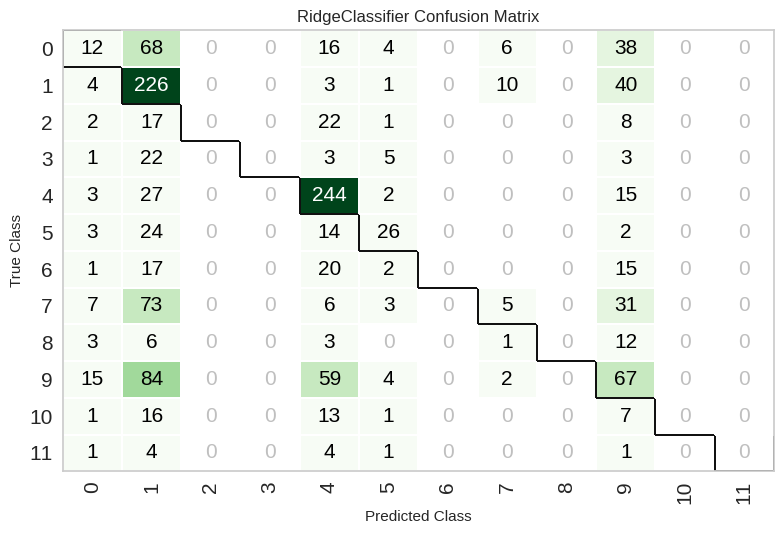

In [22]:
plot_model(best, plot='confusion_matrix')

In [26]:
# plot_model(best, plot='auc')

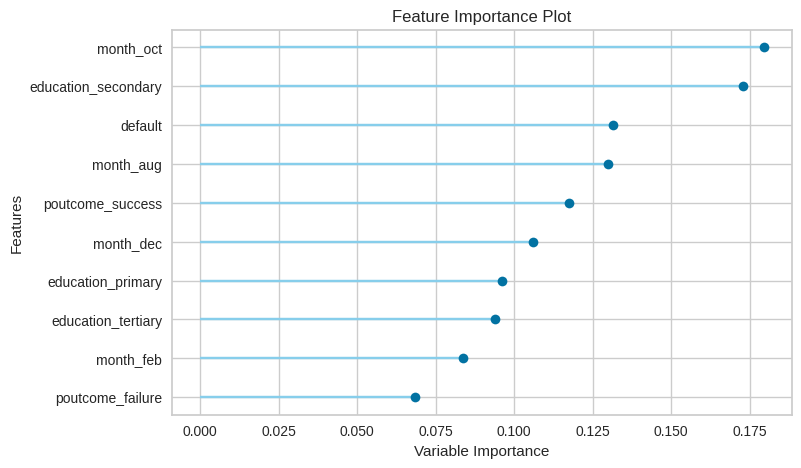

In [25]:
plot_model(best, plot='feature')

In [27]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## prediction

In [28]:
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.4274,0,0.4274,0.3269,0.3488,0.2913,0.3065


In [29]:
holdout_pred.head()

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,job,prediction_label
3953,40,married,tertiary,no,51,no,no,cellular,19,aug,164,2,-1,0,unknown,no,management,management
2478,50,divorced,secondary,no,769,no,no,cellular,28,jul,72,2,363,4,failure,no,admin.,technician
1241,22,single,unknown,no,549,no,no,cellular,2,sep,154,1,-1,0,unknown,no,student,blue-collar
3386,32,married,secondary,no,517,yes,no,unknown,5,may,528,1,-1,0,unknown,no,blue-collar,blue-collar
2046,21,single,secondary,no,1903,yes,no,unknown,29,may,107,2,-1,0,unknown,no,services,blue-collar


In [30]:
new_data = data.copy()
new_data.drop('job', axis=1, inplace=True)
new_data.head()

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,30,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [31]:
predictions = predict_model(best, data=new_data)
predictions.head()

,age,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,prediction_label
0,30,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no,blue-collar
1,33,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no,blue-collar
2,35,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no,management
3,30,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no,management
4,59,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no,blue-collar


## save model

In [32]:
save_model(best, 'bank_marketing_job_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['age', 'balance', 'day',
                                              'duration', 'campaign', 'pdays',
                                              'previous'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep...
                                     transformer=OneHotEncoder(cols=['marital',
                                                                     'education',


In [33]:
# load
loaded_best_pipeline = load_model('bank_marketing_job_pipeline')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['age', 'balance', 'day',
                                             'duration', 'campaign', 'pdays',
                                             'previous'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_valu...
                                    transformer=OneHotEncoder(cols=['marital',
                                                                    'education',
                                                                    'contact',
                                                                    'month',
                                                                    'poutcome'],
                                                              drop_invariant=False,
                                                              handle_missing='return_nan',
                                                              handle_unknown='value',
                                                              return_df=True,
                                                              use_cat_names=True,
                                                              verbose=0))),
                ('trained_model',
                 RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True,
                                 fit_intercept=True, max_iter=None,
                                 positive=False, random_state=4169,
                                 solver='auto', tol=0.0001))],
         verbose=False)